# Forecast of rewards on Cardano mainnet

We plot the history of fees and rewards from the Reserves and make a simple, conservative forecast of future rewards, assuming "business as usual" behavior.

## Load libraries for data analysis

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Plot historical rewards

## Historical data on rewards

We query `cardano-db-sync` for `mainnet`.

```sql
create schema rwrd;

create table rwrd.history as
select
    earned_epoch as "Epoch earned"
  , 'Leader' as "Category"
  , - sum(amount) / 1e6 as "Amount [ADA]"
  from reward
  where earned_epoch between 225 and 550
    and type = 'leader'
  group by earned_epoch
union all
select
    earned_epoch
  , 'Member'
  , - sum(amount) / 1e6
  from reward
  where earned_epoch between 225 and 550
    and type <> 'leader'
  group by earned_epoch
union all
select
    epoch_no - 1
  , 'Fees'
  , fees / 1e6
  from ada_pots
  where epoch_no - 1 between 225 and 550
union all
select
    earned_epoch
  , 'Reserve'
  , (sum(amount) - fees) / 1e6
  from reward
  inner join ada_pots
    on earned_epoch = epoch_no - 1
  where earned_epoch between 225 and 550
  group by earned_epoch, epoch_no, fees
;

\copy rwrd.history to 'rwrd_history.csv' csv header
```

In [2]:
rewardHistory <- fread("rwrd_history.csv", stringsAsFactors=TRUE)
rewardHistory %>% summary

  Epoch earned      Category    Amount [ADA]      
 Min.   :225.0   Fees   :326   Min.   :-13622277  
 1st Qu.:306.0   Leader :326   1st Qu.: -4267226  
 Median :387.5   Member :326   Median :  -458738  
 Mean   :387.5   Reserve:326   Mean   :        0  
 3rd Qu.:469.0                 3rd Qu.:  2145688  
 Max.   :550.0                 Max.   : 16705106  

### Disposition of rewards

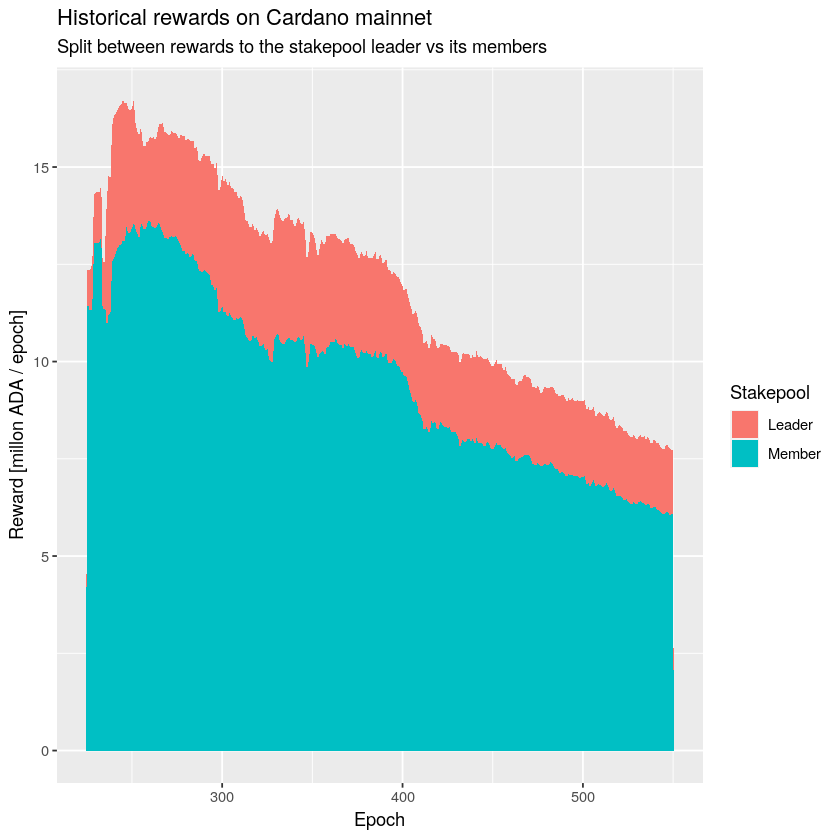

In [3]:
ggplot(
    rewardHistory[
        `Category` %in% c("Leader", "Member"),
        .(
            `Epoch`=`Epoch earned`,
            `Stakepool`=`Category`,
            `Reward [millon ADA / epoch]`=-`Amount [ADA]`/1e6
        )], 
    aes(x=`Epoch`, y=`Reward [millon ADA / epoch]`, fill=`Stakepool`)
) +
    geom_area() +
    ggtitle(
        "Historical rewards on Cardano mainnet",
        subtitle="Split between rewards to the stakepool leader vs its members"
    )

In [4]:
ggsave("reward-history-disposition.png", units="in", dpi=150, width=8, height=6)

In [5]:
ggsave("reward-history-disposition.svg", units="in", dpi=150, width=8, height=6)

### Source of funds for rewards

Conceptually, some of the rewards come from fees and some from the Reserve.

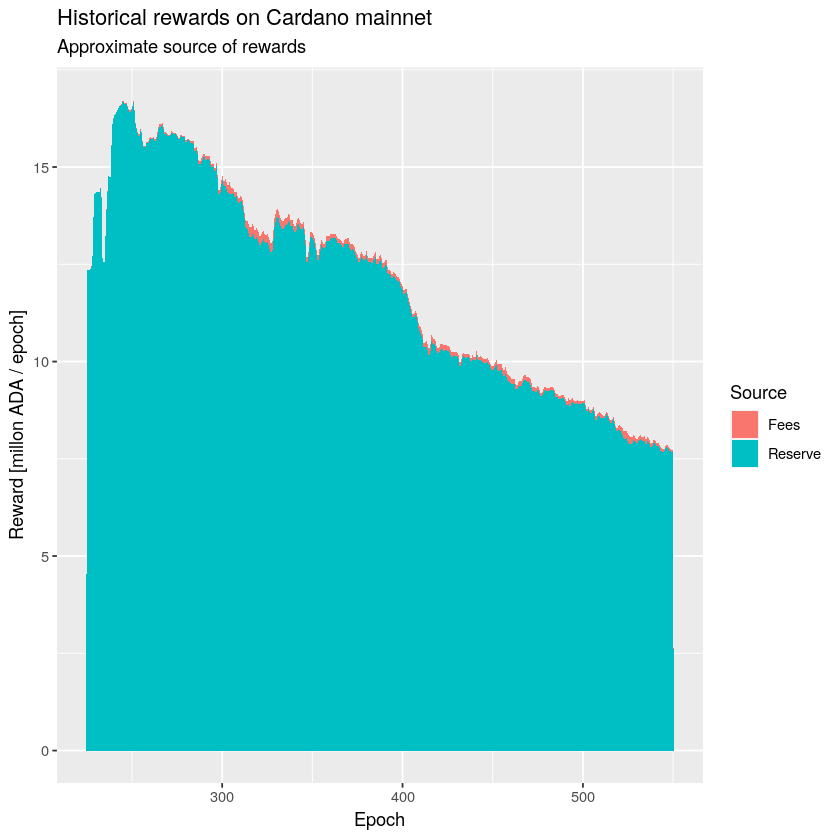

In [6]:
ggplot(
    rewardHistory[
        `Category` %in% c("Fees", "Reserve"),
        .(
            `Epoch`=`Epoch earned`,
            `Source`=`Category`,
            `Reward [millon ADA / epoch]`=`Amount [ADA]`/1e6
        )], 
    aes(x=`Epoch`, y=`Reward [millon ADA / epoch]`, fill=`Source`)
) +
    geom_area() +
    ggtitle(
        "Historical rewards on Cardano mainnet",
        subtitle="Approximate source of rewards"
    )

In [7]:
ggsave("reward-history-source.png", units="in", dpi=150, width=8, height=6)

In [8]:
ggsave("reward-history-source.svg", units="in", dpi=150, width=8, height=6)

## Forecasting model of future rewards

See the [Cardano Throughput Simulator](https://www.insightmaker.com/insight/4DU4kmFVCFDaq30ux29PCe/Cardano-Throughput-v0-3) for simplified equations for estimating the future evolutation of rewards. The [ledger specification](https://github.com/intersectmbo/cardano-ledger/releases/latest/download/shelley-ledger.pdf) defines the exact algorithm for that computation, but it is quite complex.

The intake of fees, the fraction of ada staked, the efficiency of block producers, and withdrawals from the Treasury are the primary factors that vary over time and cause the rewards to fluctuate from epoch to epoch.

In [9]:
rewards <- function(reserve, fees, staked=0.53, efficiency=0.981, treasury=0.20, expansion=0.003, total=45e9) {
    unreserved <- 1 - reserve / total
    dr1 <- efficiency * expansion * reserve
    pot <- fees + dr1
    toTreasury <- treasury * pot
    R <- (1 - treasury) * pot
    stakedOfTotal <- staked  # This is a conservative assumption.
    approx <- stakedOfTotal * unreserved * R
    dr2 <- R - approx
    fromReserve <- dr1 - dr2
    list(
        reward=fees + fromReserve - toTreasury, 
        fees=fees, 
        toTreasury=toTreasury, 
        fromReserve=fromReserve
    )
}

Check that we approximately reproduce Epoch 550. Compare with [CardanoScan](https://cardanoscan.io/epoch/550).

In [10]:
rewards(7275303870.393836, 67431.504009, staked=0.53)

$reward
[1] 7634597

$fees
[1] 67431.5

$toTreasury
[1] 4295730

$fromReserve
[1] 11862895

The forecast consists of repeatedly applying the rewards function, assuming that other parameters remain unchanged.

In [11]:
makeForecast <- function(reserve, fees, start, end, staked=0.65, efficiency=0.981, treasury=0.20, expansion=0.003, total=45e9) {
    if (start > end) {
        c()
    } else {
        result <- rewards(reserve, fees, staked, efficiency, treasury, expansion, total)
        c(
            result$reward, 
            makeForecast(reserve - result$fromReserve - result$toTreasury, fees, start+1, end, staked, efficiency, treasury, expansion, total)
        )
    }
}

Assume that fees stay constant at the recent average of 93259.681408647059 million ADA per epoch.

```sql
select sum(fees) / 1e6 / count(*) as avg_fees
  from ada_pots
  where epoch_no - 1 between 500 and 550
;
```

```console
      avg_fees
--------------------
 93259.681408647059
(1 row)
```

In [12]:
forecastFees <- data.table(
    `Epoch earned`=551:1000,
    `Category`="Fees (forecast)",
    `Amount [ADA]`=93259.681408647059
)

Compute the future rewards.

In [13]:
forecastReserve <- data.table(
    `Epoch earned`=551:1000,
    `Category`="Reserve (forecast)",
    `Amount [ADA]`=makeForecast(
        reserve=7275303870.393836 - 93259.681408647059 + 67431.504009, # Align Epoch 550 fees with longer-term average.
        fees=93259.681408647059, 
        start=551, 
        end=1000, 
        staked=0.53
    )
)

For convenience, we want to display results in terms of the year in addition to the epoch.

In [14]:
epochToYear <- function(epoch) {
    2025.259446 + (epoch - 550) * 5 / 365.24
}

Plot the forecast.

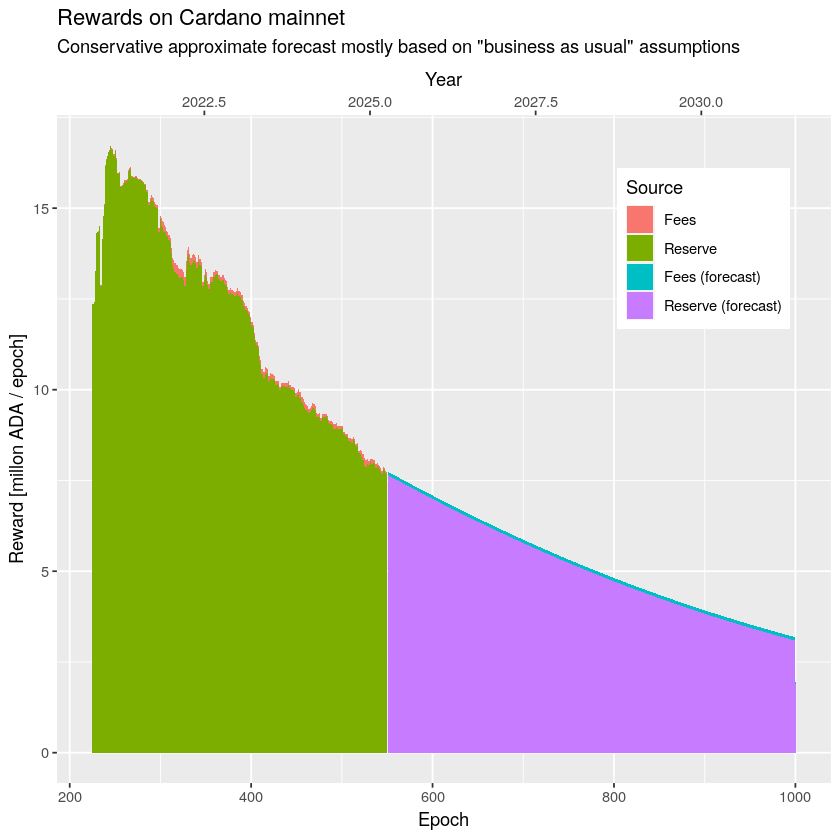

In [15]:
ggplot(
    rbind(
        rewardHistory[`Category` %in% c("Fees", "Reserve")],
        forecastFees,
        forecastReserve
    )[,
        .(
            `Epoch`=`Epoch earned`,
            `Source`=`Category`,
            `Reward [millon ADA / epoch]`=`Amount [ADA]`/1e6
        )],
    aes(x=`Epoch`, y=`Reward [millon ADA / epoch]`, fill=`Source`)
) +
    geom_area() +
    scale_x_continuous(
      sec.axis = sec_axis(~ epochToYear(.), name = "Year")
    ) +
    ggtitle(
        "Rewards on Cardano mainnet",
        subtitle="Conservative approximate forecast mostly based on \"business as usual\" assumptions"
    ) +
    theme(legend.position=c(0.835,0.8))

In [16]:
ggsave("reward-forecast-bau.png", units="in", dpi=150, width=8, height=6)

In [17]:
ggsave("reward-forecast-bau.svg", units="in", dpi=150, width=8, height=6)